#### Load libraries 

In [2]:
# Data processing 
import pandas as pd

# Statistics
import scipy as sp
import numpy as np
import statsmodels
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

# Machine learning & Deep learning
from sklearn import preprocessing
from sklearn import manifold
from sklearn.cross_validation import KFold
import xgboost as xgb

# Grid Search & Cross Validation
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.api import qqplot
sns.set_style('darkgrid')
%matplotlib inline

dark_colors = ["#99D699", "#B2B2B2"]

#### Import dataset and make it into a DataFrame

In [3]:
# import dataset
data = pd.read_csv('/home/stan/Documents/dev/Time_Series/Corn_m.csv') # need to specify your path
data = data.sort_index(axis=0,ascending=False) 
data['Trade Date'] = data['Date']
data['Open Price'] = data['Open(QCc1)']
data = data.drop('Date',axis =1)
data = data.drop('Open(QCc1)',axis = 1)
data['Trade Date'] = pd.to_datetime(data['Trade Date'])
#data
data.head()

,Trade Date,Open Price
240,1996-02-29,367.50
239,1996-03-31,395.50
238,1996-04-30,409.00
237,1996-05-31,466.00
236,1996-06-30,477.25


#### Amount of observations

In [13]:
data.shape

(241, 2)

In [14]:
data.tail()

,Trade Date,Open Price
4,2015-10-31,387.75
3,2015-11-30,381.25
2,2015-12-31,365.25
1,2016-01-31,359.50
0,2016-02-29,371.00


#### Split dataset into train and test

In [15]:
# train & test split
# train data
tr_data = data[:-12]
# test data
te_data = data[-12:] 

data.index = data['Trade Date']
data = data.drop('Trade Date',axis =1)

# train
tr_data.index = tr_data['Trade Date']
tr_data = tr_data.drop('Trade Date',axis = 1)

# test
te_data.index = te_data['Trade Date']
te_data = te_data.drop('Trade Date',axis = 1)

#### Plot the time series

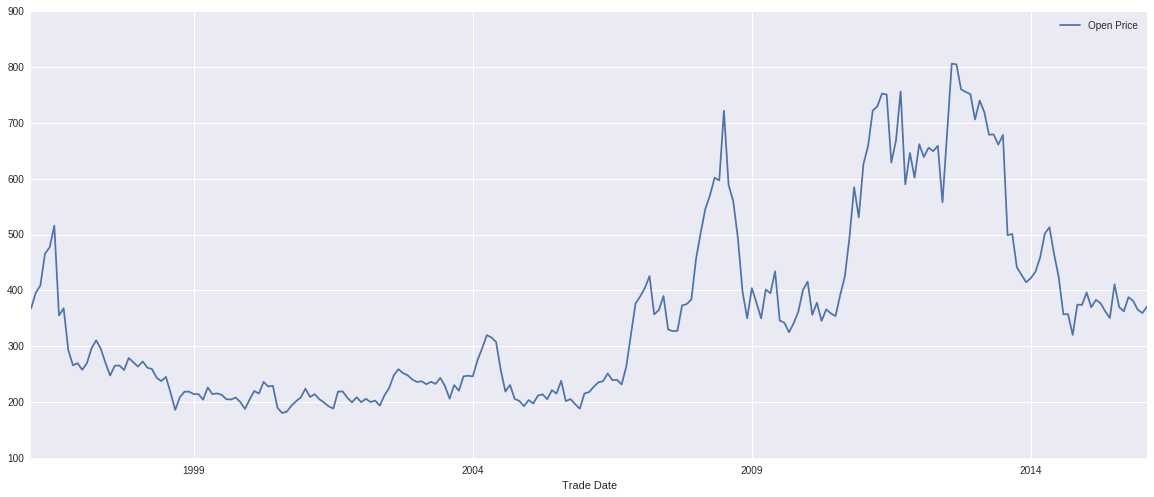

In [8]:
# plot the train dataset
data.plot(figsize=(20,8))

In [9]:
data.values[0:5].flatten()

array([ 367.5 ,  395.5 ,  409.  ,  466.  ,  477.25])

#### 2. Stationarity and differencing


In [16]:
# null hypothesis: there is unit root, i.e. series is a random walk, i.e. it is not stationary
regres = sm.tsa.stattools.adfuller(data['Open Price'], regression='ct', regresults=True)
# if p<0.05 null hypothesis can be rejected
regres

(-1.9504752955945031,
 0.62813054011503344,
 {'1%': -3.9992146562360888,
  '10%': -3.1385183923675672,
  '5%': -3.4300102058154156},
 <statsmodels.tsa.stattools.ResultsStore at 0x7f27906ce710>)

##### p-value

In [85]:
regres[1]

0.62813054011503344

#### First-order differencing to check stationarity

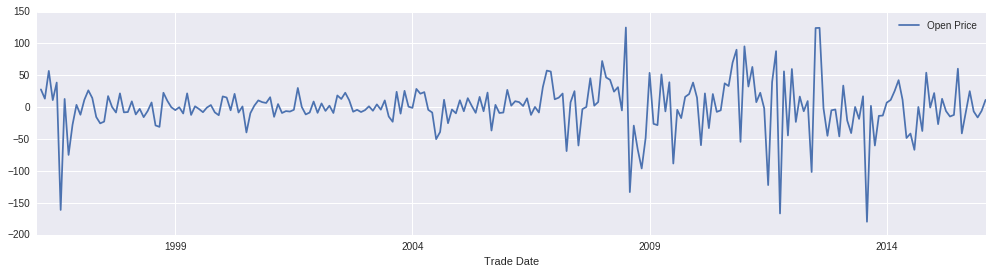

In [58]:

diff1 = data.diff(1)
diff1.plot(figsize=(17,4))

#### ADF test on the differenced time series

In [19]:
# null hypothesis: there is unit root, i.e. series is a random walk, i.e. it is not stationary
regres = sm.tsa.stattools.adfuller(diff1['Open Price'][1:], regression='ct', regresults=True)
# if p<0.05 null hypothesis can be rejected
regres

(-3.6908086218845808,
 0.022969711401006589,
 {'1%': -3.9997641267986688,
  '10%': -3.1386730729973351,
  '5%': -3.430274123136559},
 <statsmodels.tsa.stattools.ResultsStore at 0x7f27906e35c0>)

#### Seasonality detection

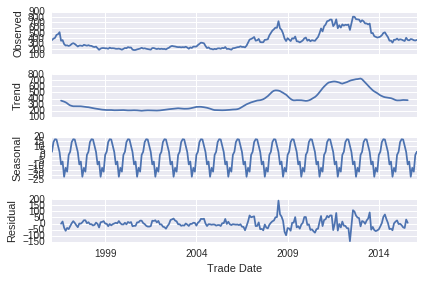

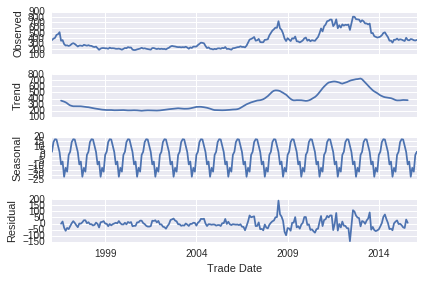

In [61]:
res = sm.tsa.seasonal_decompose(data['Open Price'])
res.plot()

#### Find proper p & q

In [21]:
data1 = data.diff(1)
data2 = data1.dropna() # we now use differenced data

In [22]:
data2.head()

,Open Price
Trade Date,
1996-03-31,28.00
1996-04-30,13.50
1996-05-31,57.00
1996-06-30,11.25
1996-07-31,38.75


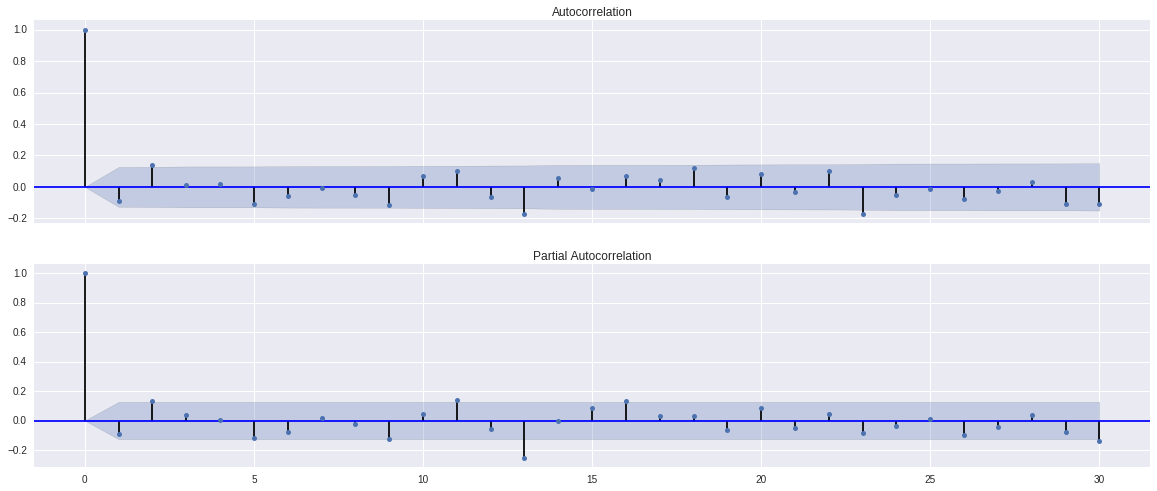

In [23]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(20,8))

# acf plot
fig = sm.graphics.tsa.plot_acf(data2,lags=30,ax=ax1)

# pacf plot (partial autocorrelation plot)
fig = sm.graphics.tsa.plot_pacf(data2,lags=30,ax=ax2)

Data set is only correlated with one lag what may suggest p=1.

#### Apply ARIMA model on different values of p and q and select one with small BIC (information cirterion) value

In [24]:
sm.tsa.stattools.arma_order_select_ic(data['Open Price'], max_ar=5, max_ma=5)

/usr/share/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/share/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/share/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/share/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/share/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to conver

{'bic':              0            1            2            3            4  \
 0  3151.425515  2914.293183  2763.626778  2687.801686  2602.120747   
 1  2470.658768  2475.046045  2474.687459  2478.966505  2484.146400   
 2  2474.704124  2476.039660  2479.089021  2484.387867  2486.426632   
 3  2475.034395  2479.924227          NaN          NaN  2481.665530   
 4  2479.791887  2485.251336  2488.287649  2487.700796  2491.392555   
 5  2485.152976  2487.469309  2480.236061  2491.329784  2489.330387   
 
              5  
 0  2581.232135  
 1  2488.423297  
 2  2493.834764  
 3  2484.192029  
 4  2496.752347  
 5  2502.800641  , 'bic_min_order': (1, 0)}

#### General purpose function to automatically apply Box-Jenkins procedure

Outputs a dictionary of predictions for 12 months and diagnostic statistics

In [25]:
def predict_ts(ts):
    flag=True
    d=0
    org_ts=ts.copy()
    #difference ts
    while(flag):
        regres = sm.tsa.stattools.adfuller(ts, regression='ct', regresults=True)
        if regres[1]<0.05:
            flag=False
        else:
            ts=ts.diff(1).dropna()
            d+=1
    #select p and q
    try:
        pqselect = sm.tsa.stattools.arma_order_select_ic(ts)
        p,q=pqselect.bic_min_order
        if p==0 and q==0:
            p=5
            q=2
    except:
        p=5
        q=2
        
    arima = sm.tsa.ARIMA(org_ts,(p,d,q)).fit()
    
    # Ljung-Box test
    r,q,p = sm.tsa.acf(arima.resid.values.squeeze(), qstat=True)
    LB_data = np.c_[range(1,41), r[1:], q, p]
    table = pd.DataFrame(LB_data, columns=['lag', "AC", "Q", "Prob(>Q)"])
    print('Ljung-box test talbe is as follows:' )
    print('-----------------------------------')
    print('                                   ')
    print(table.set_index('lag').head(12))
    
    dw = sm.stats.durbin_watson(arima.resid.values)
    forecast = arima.forecast(12)[0]
    return {'arima': arima, 'prediction':forecast, 'spec': (p,d,q), 'dw': dw, 'lb': LB_data}

#### Model prediction

In [26]:
res = predict_ts(tr_data['Open Price'])

Ljung-box test talbe is as follows:
-----------------------------------
                                   
           AC         Q  Prob(>Q)
lag                              
1   -0.026260  0.159309  0.689794
2    0.040812  0.545800  0.761169
3   -0.043729  0.991466  0.803317
4    0.067694  2.064268  0.723939
5   -0.037064  2.387304  0.793363
6   -0.089691  4.287554  0.637825
7   -0.057800  5.080280  0.650167
8   -0.040050  5.462620  0.707178
9   -0.052810  6.130415  0.726798
10   0.055910  6.882364  0.736502
11   0.063678  7.862251  0.725588
12  -0.067138  8.956565  0.706636


/usr/share/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


function predict_ts outputs Ljung-box tests outcomes

#### Genreal function to evaluate prediction results

In [35]:
def evaluate_prediction(te_data, predict):
    err = np.subtract(te_data.values.flatten(), predict.flatten())
    abserr = np.absolute(err)
    mae = np.mean(abserr)
    perc_err = np.divide(abserr, te_data.values.flatten())
    perc_mae = np.mean(perc_err)
    return mae, perc_mae

In [36]:
predict = res['prediction']

In [27]:
arima = res['arima']

Plot scatter graph of resuduals

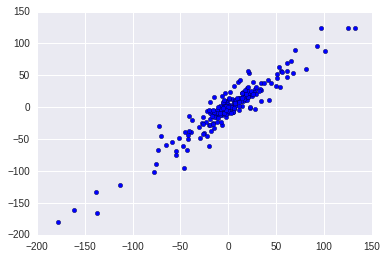

In [33]:
plt.scatter(arima.resid.values, tr_data['Open Price'].diff(1).dropna())
plt.show()

Test null hypothesis of zero mean for residuals

In [39]:
t, p = sp.stats.ttest_1samp(arima.resid.values, 0)
p

0.98638794888399206

In [45]:
te_data

,Open Price
Trade Date,
2015-03-31,383.00
2015-04-30,377.00
2015-05-31,362.50
2015-06-30,350.50
2015-07-31,411.00
2015-08-31,370.00
2015-09-30,362.50
2015-10-31,387.75
2015-11-30,381.25


Calculate error rate

In [37]:
mae, per_mae = evaluate_prediction(te_data, predict)

In [38]:
mae

19.924914240413298

In [39]:
per_mae

0.051992166557247609

#### Draw predictions

/usr/share/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/arima_model.py:1847: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


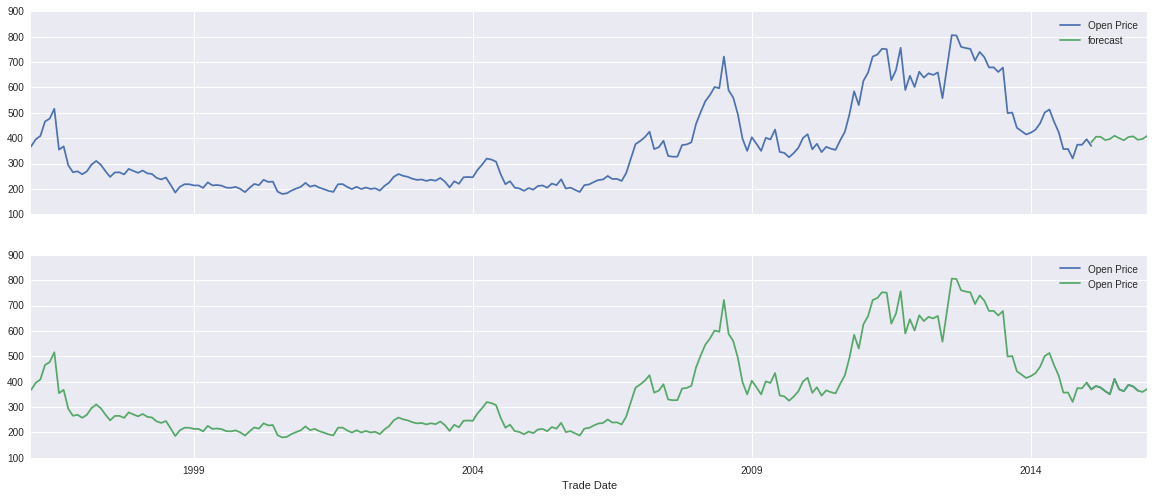

In [52]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(20,8))

ax1 = tr_data.ix['1980':].plot(ax=ax1)
fig = arima.plot_predict('2015-02-28','2016-02-29', dynamic= True, ax=ax1, plot_insample=False, alpha=0.05)

ax2 = data.ix['2015'].plot(ax = ax2)
data.plot(ax = ax2)
